# Ekman Transport with Yodapy

## Background

Ekman transport is a phenomenon in coastal upwelling systems that describes the direction magnitude of water currents in a single water column with sustained, constant wind. Friction between wind and the water surface pulls the surface layer of water in the same direction as the wind. However, due to the Coriolis effect, the surface layer of water is actually deflected 45 degrees (eastward in the northern hemisphere, and westward in the southern hemisphere).

![Ekman Spiral](http://oceanmotion.org/images/ocean-in-motion_clip_image001.jpg)

As seen in the above image, the same frictional effect between surface wind and surface water propagtes downward, creating a spiral of ever-decreasing magnitude. The net water movement of the spiral is predicted to be 90 degrees in the direction of the initial deflection.

![Top-down View](http://oceanmotion.org/images/figb-ocean-in-motion.jpg)

This net water movement plays an important role in cyclonic winds, coastal upwelling and downwelling, and equatorial upwelling and downwelling. In this notebook, we demonstrate how to use the OOI Data Portal to analyze Ekman transport in real time. We generate two plots: a 3D vector stack of currents in the water column (described in detail in the accompanying notebook Current Stack) and a comparison of the wind vector, predicted net water movement, and actual net water movement.

[Image Credit: NASA](http://oceanmotion.org/html/background/ocean-in-motion.htm)

## Requesting Data

We begin by acquiring our data: water currents and the wind vector at the same moment in time at relatively the same location. Fortunately, an example readily presents itself at Site 2 of the Coastal Endurance array. Using the ADCP located on the [benthic experiment package](http://oceanobservatories.org/site/ce02shbp/) and the meteorology package on the [surface mooring](http://oceanobservatories.org/site/ce02shsm/), we can make our requests.

In [1]:
# set up data access
from yodapy.datasources import OOI
from yodapy.utils import set_credentials_file

set_credentials_file(data_source='ooi', username='OOIAPI-CHN725DB03M3AC', token='SAFZTAB3M1')

In [2]:
#meteorology instrument
mooi = OOI()
meteor = mooi.filter(region="coastal endurance",site="oregon shelf surface mooring",
                         instrument="bulk meteorology instrument package")
meteor.view_instruments()

,reference_designator,name,start_depth,end_depth,current_status,preferred_stream,preferred_parameter,location
65,CE02SHSM-SBD11-06-METBKA000,Bulk Meteorology Instrument Package,-3.0,-3.0,,metbk_a_dcl_instrument,1053,Buoy Tower


In [3]:
#current instrument
cooi = OOI()
current = cooi.filter(region="coastal endurance",site="oregon shelf surface mooring",instrument="velocity profiler")
current.view_instruments()

,reference_designator,name,start_depth,end_depth,current_status,preferred_stream,preferred_parameter,location
50,CE02SHSM-RID26-01-ADCPTA000,Velocity Profiler (600kHz),7.0,7.0,,adcp_velocity_earth,,Near Surface Instrument Frame


In [4]:
start = "2017-04-19"
stop = "2017-04-21"

# make requests
# indexing and keys at the end of request convert raw json format to a dictionary of data types we care about
data = [meteor.request_data(begin_date=start,end_date=stop,limit=2,data_type="json").raw()[0]["data"][0],
        current.request_data(begin_date=start,end_date=stop,limit=2,data_type="json").raw()[0]["data"][0]
        ]

## Data Correction

Occasionally, ADCP readings towards the top of the water column will get pretty ugly. This is because there is interference from waves or wind that throw off the readings, as if the instrument were trying to detect movement above the water's surface. We don't want to totally omit this, since Ekman transport studies the interaction of current and wind! Instead, we can trim the current arrays once the data degrades into nans.

In [5]:
# for detecting nans
import numpy as np

x = data[1]["eastward_seawater_velocity"]
y = data[1]["northward_seawater_velocity"]

def find_nan(arr):
    for i in range(0,len(arr)):
        if np.isnan(arr[i]):
            return i
    return -1

nan_i = min([find_nan(x), find_nan(y)])

if nan_i != -1:
    x = x[:nan_i]
    y = y[:nan_i]

## Plotting

We create the two plots described above, beginning with the vector stack of water currents. Unfortunately, this will require two blocks of code, since matplotlib does not allows us to add a 3D subplot. Additionally, the net movement predicted by Ekman transport rotates 45 degrees clockwise relative to the wind vector since the measurement was taken in the northern hemisphere. In the southern hemisphere, we would rotate counter-clockwise.

To rotate the vector we apply the clockwise rotation matrix:

$$\begin{bmatrix}
cos\theta & sin\theta \\
-sin\theta & cos\theta
\end{bmatrix}$$

with $\theta = -\frac{\pi}{2}$, or:

$$
x' = -y \\
y' = x
$$

We can quickly perform this transformation by reversing the order of our vector and multiplying the first element by -1.

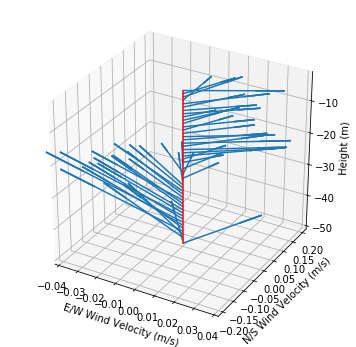

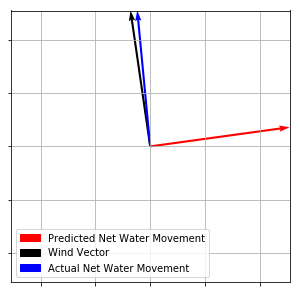

In [9]:
%matplotlib inline
# follows scheme outlined in Current Stack 

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

fig = plt.figure(figsize=(6,6))
ax1 = plt.subplot(111,projection="3d")

# flip z values for easy viewing
z = [float(i * -1) for i in data[1]["bin_depths"][:nan_i]]
zeros = [0 for i in z]
ax1.set_xlim(-max(x), max(x))
ax1.set_ylim(-max(y), max(y))
ax1.set_xlabel("E/W Wind Velocity (m/s)")
ax1.set_ylabel("N/S Wind Velocity (m/s)")
ax1.set_zlabel("Height (m)")
ax1.quiver(zeros, zeros, z, x, y, zeros)
ax1.plot(zeros, zeros, z, c="red")

# new figure
fig2 = plt.figure(figsize=(5,5))
ax2 = plt.subplot(111)
# turn on gridlines
ax2.grid()

# take average of x/y components
avg_current = np.mean(x),np.mean(y)
# pull in wind data from meteorology package
wind = data[0]["eastward_wind_velocity"],data[0]["northward_wind_velocity"] 

# find the data point with the greatest absolute value, set axis limits accordingly
mag = max(np.absolute(wind + avg_current))
ax2.set_xlim(-mag,mag)
ax2.set_ylim(-mag,mag)
# hide tick marks (we care about direction, not scale here)
ax2.xaxis.set_ticklabels([])
ax2.yaxis.set_ticklabels([])
# plot wind (BLACK)
ax2.quiver(0,0,wind[0],wind[1],color="black",scale=1.0,angles="xy",scale_units="xy")
# plot avg current, scale value gives it max possible length (BLUE)
ax2.quiver(0,0,avg_current[0],avg_current[1],color="blue",scale=max(np.absolute(avg_current)) / mag,angles="xy",scale_units="xy")
# transform wind vector (x,y) -> (-y,x), plot predicted water movement (RED)
ekman = list(reversed(wind))
ax2.quiver(0,0,ekman[0],-ekman[1],color="red",scale=max(np.absolute(ekman)) / mag,angles="xy",scale_units="xy")

# add legend entries
patches = [mpatches.Patch(color="red",label="Predicted Net Water Movement"),
           mpatches.Patch(color="black",label="Wind Vector"),
           mpatches.Patch(color="blue",label="Actual Net Water Movement")]

ax2.legend(handles=patches,loc=3)

## Your Turn

In the above figure, it appears that the actual net water movement follows the wind vector much more closely than what Ekman transport predicts. Perhaps this is because of inconsistent wind direction, or maybe because the wind is not strong enough to produce a proper Ekman spiral. Or, other phenomena lower in the water column mess up the measurement. Note that in the vector stack, it appears we have two distinct sections of current rather than a continuous spiral.

